In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
tf.keras.utils.set_random_seed(32)
tf.config.experimental.enable_op_determinism()


In [37]:

def parse_data(file_path):
    sequences = []
    labels = []
 
    with open(file_path, "r") as file:
        for line in file:
            if line == "end\n" or line == "<end>":
                sequences.append("end")
                labels.append("end")
                #print("End of sequence")
            elif len(line) == 4:
                sequences.append(line[0]) # Amino acid
                labels.append(line[2]) # e, h, _
                          
            else:
                #print("Something else")
                #print(line)
                pass
        
    
    return sequences, labels

def encode_seqeuences(sequences):
    amino_acid_mapping = {
    'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
    'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
    'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
    'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19,
    'end': 20
    }
    encoded_seqs = []
    for amino_acid in sequences:
        encoding = [0]*21
        encoding[amino_acid_mapping[amino_acid]] = 1
        encoded_seqs.append(encoding)

    return encoded_seqs

def encode_labels(labels):
    label_mapping = {
    'e': 0, 'h': 1, '_': 2, 'end': 3
    }
    #print("encoding labels")
    encoded_labels = []
    for label in labels:
        encoded_label = [0,0,0]
        if label_mapping[label] != 3:
            encoded_label[label_mapping[label]] = 1
        encoded_labels.append(encoded_label)
    return encoded_labels

    
seq,labels = parse_data("protein-secondary-structure.train.txt")
#print(seq)
eseq = encode_seqeuences(seq)
#print(labels)
elab = encode_labels(labels)


In [39]:

def build_model(input_shape):
    learning_rate = 0.001
    #optim = Adam(learning_rate=learning_rate)
    optim = 'adam'
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Hidden layer with 40 units
        Dense(3, activation='softmax')  # Output layer for the three types of secondary structures
    ])
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def create_sliding_windows(encoded_seqs, window_size=13):
    # Padding to handle boundaries
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    
    # Create sliding windows
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows


In [40]:

windowed_input = create_sliding_windows(np.array(eseq))


# Assuming elab is already one-hot encoded
X_train, X_test, y_train, y_test = train_test_split(windowed_input, elab, test_size=0.2, random_state=42)
# Build the model with the correct input shape
model = build_model(X_train.shape[1])
y_train = np.array(y_train)
y_test = np.array(y_test)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)


Epoch 1/100
455/455 [==============================] - 2s 2ms/step - loss: 0.9414 - accuracy: 0.5411 - val_loss: 0.8770 - val_accuracy: 0.5824
Epoch 2/100
455/455 [==============================] - 1s 2ms/step - loss: 0.8453 - accuracy: 0.6066 - val_loss: 0.8312 - val_accuracy: 0.6173
Epoch 3/100
455/455 [==============================] - 1s 2ms/step - loss: 0.8119 - accuracy: 0.6294 - val_loss: 0.8230 - val_accuracy: 0.6283
Epoch 4/100
455/455 [==============================] - 1s 2ms/step - loss: 0.8031 - accuracy: 0.6339 - val_loss: 0.8171 - val_accuracy: 0.6305
Epoch 5/100
455/455 [==============================] - 1s 2ms/step - loss: 0.7994 - accuracy: 0.6404 - val_loss: 0.8172 - val_accuracy: 0.6308
Epoch 6/100
455/455 [==============================] - 1s 2ms/step - loss: 0.7983 - accuracy: 0.6379 - val_loss: 0.8182 - val_accuracy: 0.6286
Epoch 7/100
455/455 [==============================] - 1s 2ms/step - loss: 0.7967 - accuracy: 0.6392 - val_loss: 0.8195 - val_accuracy: 0.6280

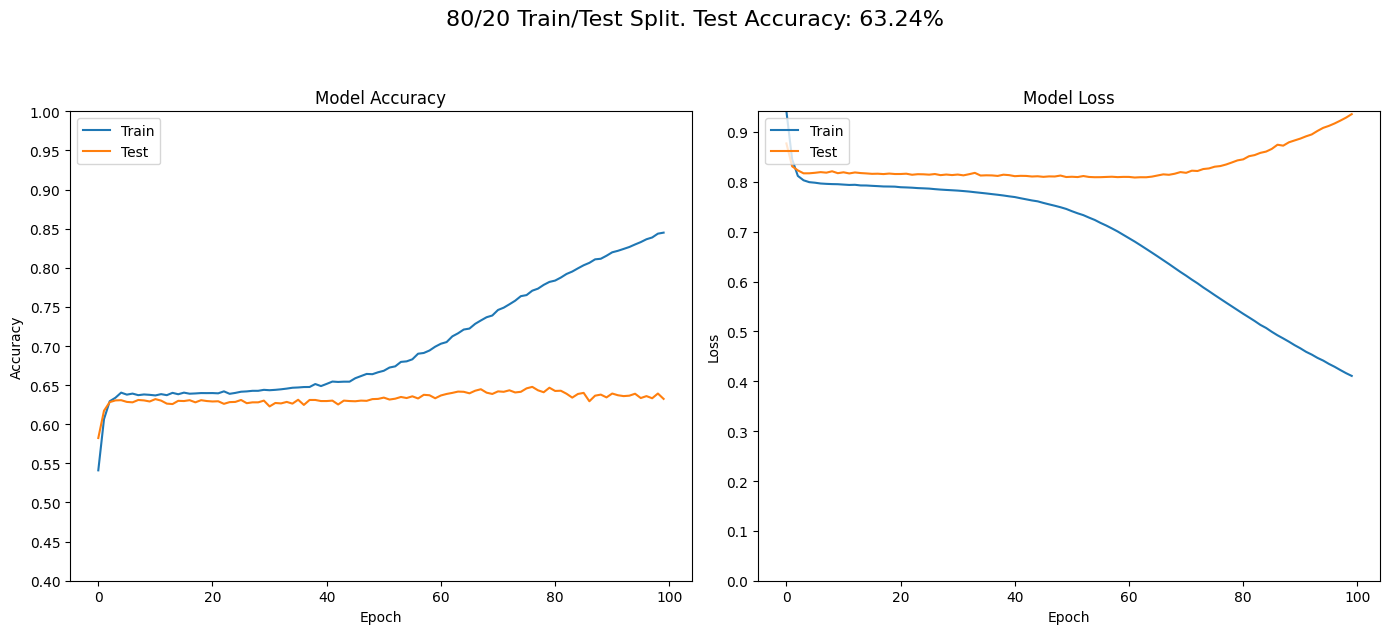

114/114 [==============================] - 0s 1ms/step
Q3 Score: 0.6324175824175824


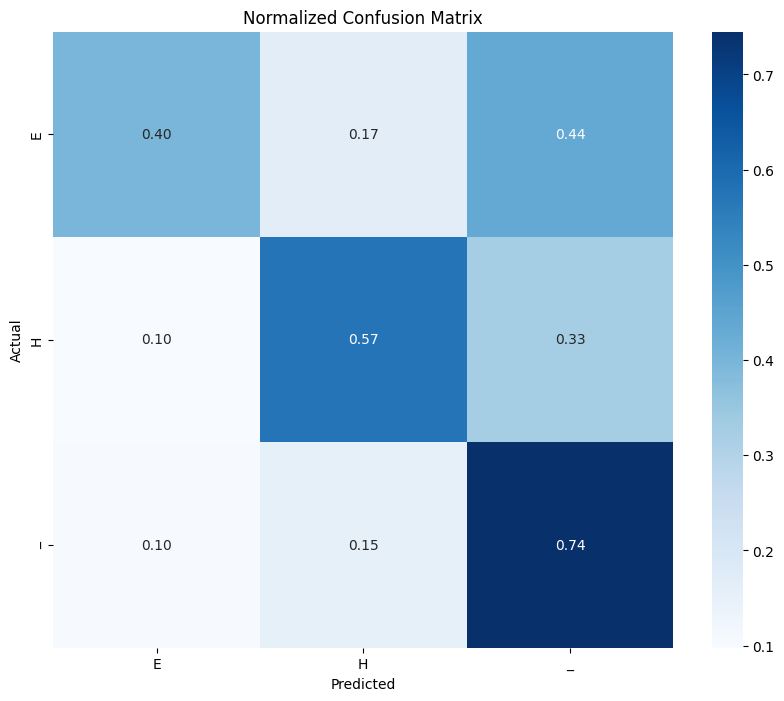

In [41]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.suptitle('80/20 Train/Test Split. Test Accuracy: ' + str(round(test_accuracy*100,2)) + '%', fontsize=16, y=1.05, x=0.5, ha='center')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks([i / 20 for i in range(21)])  # 0, 0.1, 0.2, ..., 1.0

plt.ylim(0.4, 1)  # Adjust the y-axis limit to provide space at the top

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks([i / 10 for i in range(11)])  # 0, 0.1, 0.2, ..., 1.0

plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))  # Adjust y-axis limit dynamically

# Put test accuracy as a label on the plot
# Adjust layout to remove white space
plt.tight_layout()
plt.show()


def calculate_q3_score(y_true, y_pred):
    total = len(y_true)
    correct = sum(np.argmax(y_true[i]) == np.argmax(y_pred[i]) for i in range(total))
    return correct / total

#Give me a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)


q3_score = calculate_q3_score(y_test, y_pred)
print("Q3 Score:", q3_score)
# Compute the normalized confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=['E', 'H', '_'], yticklabels=['E', 'H', '_'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()



In [42]:
def build_model_grid_search(input_shape, learning_rate, activation, units):
    #optim = Adam(learning_rate=learning_rate)
    optim = 'adam'
    model = Sequential([
        Dense(units, activation=activation, input_shape=(input_shape,)),  # Dynamic number of units
        Dense(3, activation='softmax')  # Output layer for the three types of secondary structures
    ])
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def grid_search():
    learning_rates = [0.001, 0.01, 0.1]
    activations = ['sigmoid', 'relu', 'tanh']
    batch_sizes = [32, 64, 128]
    units_options = [20, 40, 80, 160]  # Different options for the number of units in the dense layer
    epochs_options = [100, 200, 300]
    best_accuracy = 0
    best_params = {}

    for lr in learning_rates:
        for act in activations:
            for bs in batch_sizes:
                for units in units_options:
                    for ep in epochs_options:
                        print(f"Training model with lr: {lr}, activation: {act}, units: {units}, batch size: {bs}, epochs: {ep}")
                        model = build_model_grid_search(X_train.shape[1], lr, act, units)
                        history = model.fit(X_train, y_train, epochs=ep, validation_data=(X_test, y_test), batch_size=bs, verbose=0)
                        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
                        if test_accuracy > best_accuracy:
                            best_accuracy = test_accuracy
                            best_params = {
                                'learning_rate': lr,
                                'activation': act,
                                'units': units,
                                'batch_size': bs,
                                'epochs': ep
                            }
                            print(f"New best accuracy: {best_accuracy} found with parameters: {best_params}")

    print("Overall best accuracy:", best_accuracy)
    print("Best parameters:", best_params)

#grid_search()


Epoch 1/100
455/455 [==============================] - 1s 2ms/step - loss: 0.9310 - accuracy: 0.5463 - val_loss: 0.8627 - val_accuracy: 0.5953
Epoch 2/100
455/455 [==============================] - 1s 1ms/step - loss: 0.8288 - accuracy: 0.6178 - val_loss: 0.8191 - val_accuracy: 0.6277
Epoch 3/100
455/455 [==============================] - 1s 1ms/step - loss: 0.7966 - accuracy: 0.6399 - val_loss: 0.8135 - val_accuracy: 0.6319
Epoch 4/100
455/455 [==============================] - 1s 1ms/step - loss: 0.7881 - accuracy: 0.6433 - val_loss: 0.8081 - val_accuracy: 0.6302
Epoch 5/100
455/455 [==============================] - 1s 2ms/step - loss: 0.7841 - accuracy: 0.6463 - val_loss: 0.8085 - val_accuracy: 0.6316
Epoch 6/100
455/455 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.6448 - val_loss: 0.8093 - val_accuracy: 0.6324
Epoch 7/100
455/455 [==============================] - 1s 2ms/step - loss: 0.7807 - accuracy: 0.6463 - val_loss: 0.8105 - val_accuracy: 0.6346

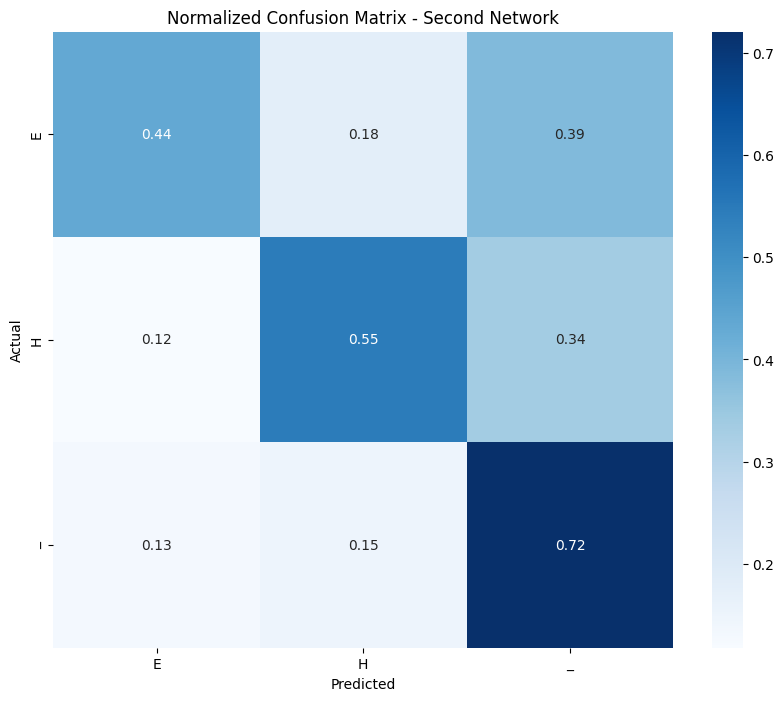

In [43]:
def create_sliding_windows(encoded_seqs, window_size):
    padding = np.zeros((window_size // 2, len(encoded_seqs[0])))  # Ensure padding matches the dimension of encoded sequences
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows

# Function to build a model
def build_model(input_shape, units=40, output_units=3, activation='sigmoid', final_activation='softmax'):
    model = Sequential([
        Dense(units, activation=activation, input_shape=(input_shape,)),
        Dense(output_units, activation=final_activation)
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming eseq is your encoded sequence and elab is your encoded labels
windowed_input_first = create_sliding_windows(np.array(eseq), window_size=17)
X_train_first, X_test_first, y_train, y_test = train_test_split(windowed_input_first, np.array(elab), test_size=0.2, random_state=42)

# Build and train the first model
first_model = build_model(X_train_first.shape[1], units=40, output_units=3, activation='sigmoid')
first_model.fit(X_train_first, y_train, epochs=100, validation_data=(X_test_first, y_test), batch_size=32)

# Prepare input for the second network using the output from the first
y_pred_train_first = first_model.predict(X_train_first)
y_pred_test_first = first_model.predict(X_test_first)

def create_second_network_input(predictions, window_size=13):
    padding = np.zeros((window_size // 2, predictions.shape[1]))
    padded_predictions = np.vstack([padding, predictions, padding])
    windows = np.array([padded_predictions[i:i + window_size].flatten() for i in range(len(predictions))])
    return windows

X_train_second = create_second_network_input(y_pred_train_first)
X_test_second = create_second_network_input(y_pred_test_first)

# Build the second model
second_model = build_model(X_train_second.shape[1], units=40, output_units=3, activation='sigmoid')
history_second = second_model.fit(X_train_second, y_train, epochs=100, validation_data=(X_test_second, y_test), batch_size=32)

# Evaluation
test_loss_second, test_accuracy_second = second_model.evaluate(X_test_second, y_test)
print("Second Test accuracy:", test_accuracy_second)

y_pred_second = second_model.predict(X_test_second)
q3_score_second = calculate_q3_score(y_test, y_pred_second)
print("Improved Q3 Score:", q3_score_second)

# Plotting new confusion matrix for the second network
cm_second = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_second, axis=1), normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_second, annot=True, fmt=".2f", cmap='Blues', xticklabels=['E', 'H', '_'], yticklabels=['E', 'H', '_'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix - Second Network')
plt.show()

In [44]:
def save_metrics(model_name, accuracy, confusion_matrix, labels):
    # Save the accuracy to a CSV file
    import pandas as pd
    accuracy_data = pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy]})
    accuracy_data.to_csv(f"{model_name}_accuracy.csv", index=False)

    # Plot and save the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()

class_labels = ['E', 'H', '_']

# Evaluate the first model
test_accuracy_first = model.evaluate(X_test, y_test)[1]
y_pred_first = model.predict(X_test)
cm_first = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_first, axis=1), normalize='true')
save_metrics("First_Network", test_accuracy_first, cm_first, class_labels)

# Evaluate the second model
test_accuracy_second = second_model.evaluate(X_test_second, y_test)[1]
y_pred_second = second_model.predict(X_test_second)
cm_second = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_second, axis=1), normalize='true')
save_metrics("Second_Network", test_accuracy_second, cm_second, class_labels)

114/114 [==============================] - 0s 832us/step
